# Disease Classification using Machine Learning

# Table of Contents

1. [Introduction](#Introduction)
    - [Overview of the Dataset](#Overview-of-the-Dataset)
    - [Objectives of the Analysis](#Objectives-of-the-Analysis)
2. [Data Loading](#Data-Loading)
    - [Importing Libraries](#Importing-Libraries)
    - [Loading the Dataset](#Loading-the-Dataset)
3. [Data Inspection](#Data-Inspection)
    - [Initial Data Exploration](#Initial-Data-Exploration)
    - [Overview of Dataset](#Overview-of-Dataset)
    - [Data Information](#Data-Information)
    - [Analyzing Prognosis Distribution for Potential Class Imbalance](#class-imbalance-analysis)
    - [Summary Statistics](#Summary-Statistics)
    - [Missing Values](#Missing-Values)
    - [Duplicate Records](#Duplicate-Records)
4. [Data Transformation](#Data-Transformation)
    - [Feature Engineering](#Feature-Engineering)
5. [Data Visualization](#Data-Visualization)
    - [Symptom Frequency Distribution](#Sympton-Frequency-Distribution)

# Introduction
<a id="Introduction"></a>

## Overview of the Dataset
<a id="Overview-of-the-Dataset"></a>
In this project, we aim to predict the disease by analyzing different symptoms a person experiences, this is captured in the last column name 'prognosis'. We have around 132 parameters on which 42 different types of diseases can be predicted. 


## Objectives of the Analysis
<a id="Objectives-of-the-Analysis"></a>
The primary objective of this project is to develop a machine-learning model that can accurately classify and cluster diseases based on patient's symptoms. This can be used to a helping tool for medical staff to help patients all around the world. Best features should be identifies while creating of the ML model.

# Data Loading
## Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import math
import seaborn as sns 
import matplotlib.pyplot as plt

## Loading the Dataset
<a id="Data-Loading"></a>

In [2]:
# Loading the Dataset (train)
train_data = pd.read_csv('data/Training.csv')
train_data = train_data.iloc[: , :-1]

# Loading the Dataset (test)
test_data = pd.read_csv('data/Testing.csv')


# Data Inspection
<a id="Data-Inspection"></a>
## Initial Data Exploration
<a id="Initial-Data-Exploration"></a>


In [3]:
# Display the first few rows of the test_data dataframe
test_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,GERD
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chronic cholestasis
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Drug Reaction


In [4]:
# Display the first few rows of the train_data dataframe
train_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


## Overview of Dataset
<a id="Overview-of-Dataset"></a>

In [5]:
total_columns = len(train_data.columns)
total_rows = len(train_data['prognosis'])
prognoses = train_data['prognosis'].unique().tolist()

print(f"The training dataset has a total of {total_rows} rows and {total_columns} columns. This means that there are {total_columns - 1} predictor variables. \nWithin the prognosis columns, there are {len(prognoses)} diseases included.")

The training dataset has a total of 4920 rows and 133 columns. This means that there are 132 predictor variables. 
Within the prognosis columns, there are 41 diseases included.


## Data Information
<a id="Data-Information"></a>

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 133 entries, itching to prognosis
dtypes: int64(132), object(1)
memory usage: 5.0+ MB


## Analyzing Prognosis Distribution for Potential Class Imbalance
<a id="class-imbalance-analysis"></a>

In [7]:
# Looking at the distribution of the prognoses within the dataset - determining if there is an imbalance 
100 * train_data.groupby('prognosis').size()/train_data.shape[0] 

prognosis
(vertigo) Paroymsal  Positional Vertigo    2.439024
AIDS                                       2.439024
Acne                                       2.439024
Alcoholic hepatitis                        2.439024
Allergy                                    2.439024
Arthritis                                  2.439024
Bronchial Asthma                           2.439024
Cervical spondylosis                       2.439024
Chicken pox                                2.439024
Chronic cholestasis                        2.439024
Common Cold                                2.439024
Dengue                                     2.439024
Diabetes                                   2.439024
Dimorphic hemmorhoids(piles)               2.439024
Drug Reaction                              2.439024
Fungal infection                           2.439024
GERD                                       2.439024
Gastroenteritis                            2.439024
Heart attack                               2.439024
He

Our dataset is a balanced one. The distribution indicates that the dataset is evenly balanced across all the diseases. Each disease makes up the same proportion of the total data (2.439024%). This means there is no class imbalance, which is crucial for training machine learning models as it helps to prevent bias toward more frequent classes. This balanced distribution should lead to more reliable and fair model performance across all disease categories.

## Summary Statistics
<a id="Summary-Statistics"></a>


In [8]:
# Display summary statistics
train_data.describe()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
count,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,...,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000
mean,0.137805,0.159756,0.021951,0.045122,0.021951,0.162195,0.139024,0.045122,0.045122,0.021951,...,0.021951,0.021951,0.021951,0.023171,0.023171,0.023171,0.023171,0.023171,0.023171,0.023171
std,0.344730,0.366417,0.146539,0.207593,0.146539,0.368667,0.346007,0.207593,0.207593,0.146539,...,0.146539,0.146539,0.146539,0.150461,0.150461,0.150461,0.150461,0.150461,0.150461,0.150461
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Missing Values
<a id="Missing-Values"></a>

In [9]:
# Check for missing values
missing_values = train_data.isnull().sum()

# Check if there are any missing values
if missing_values.sum() > 0:
    print("Missing values found in the following columns:")
    print(missing_values[missing_values > 0])  # Print only columns with missing values
else:
    print("No missing values found.")


No missing values found.


# Data Transformation
<a id="Data-Transformation"></a>
## Feature Engineering
<a id="Feature-Engineering"></a>


In [10]:
# Making things look nicer for plotting, by converting first letter of each word to upper case
train_data['prognosis'] = train_data['prognosis'].str.title() 

In [11]:
value_columns = [col for col in train_data.columns if col != 'prognosis']

# Melt the dataframe
melted_train_data = (train_data.melt(id_vars=['prognosis'], value_vars=value_columns)
                     .groupby(['prognosis', 'variable'], as_index=False)
                     .sum()
                     .query('value > 0')
                     .reset_index(drop=True))


In [12]:
melted_train_data['prognosis'] = melted_train_data['prognosis'].astype('category')
melted_train_data['variable'] = melted_train_data['variable'].astype('category')

In [13]:
melted_train_data.head()

,prognosis,variable,value
0,(Vertigo) Paroymsal Positional Vertigo,headache,114
1,(Vertigo) Paroymsal Positional Vertigo,loss_of_balance,114
2,(Vertigo) Paroymsal Positional Vertigo,nausea,114
3,(Vertigo) Paroymsal Positional Vertigo,spinning_movements,108
4,(Vertigo) Paroymsal Positional Vertigo,unsteadiness,114


# Data Visualization
<a id="Data-Visualization"></a>
## Symptom Frequency Distribution
<a id="Sympton-Frequency-Distribution"></a>

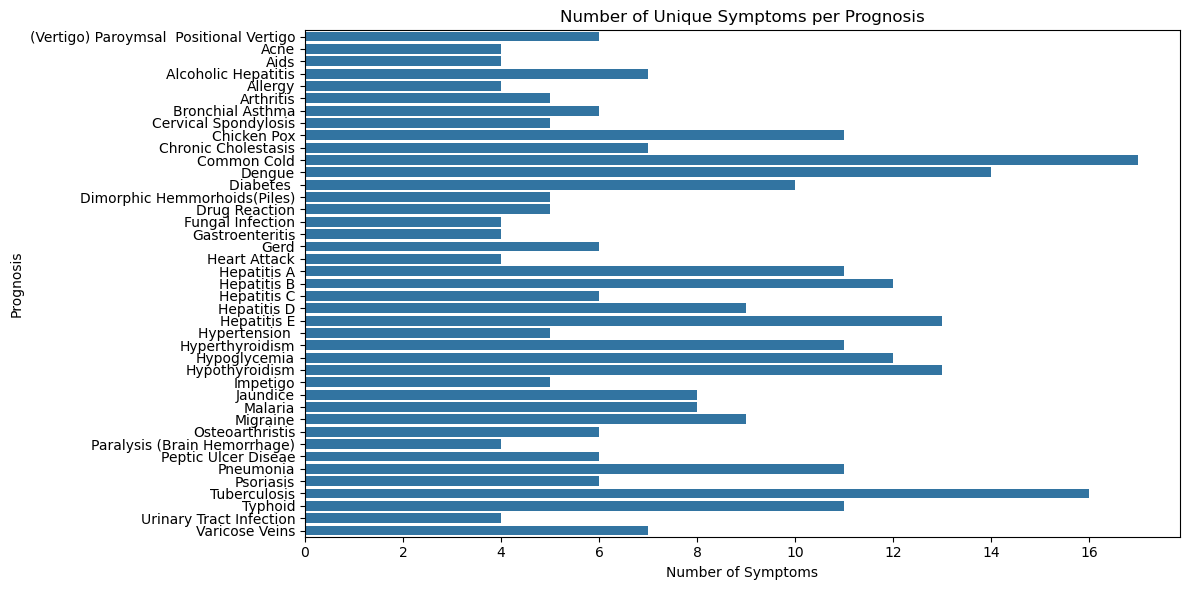

In [ ]:
symptom_counts = melted_train_data.groupby('prognosis', observed=True)['variable'].nunique().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=symptom_counts.values, y=symptom_counts.index)
plt.title('Number of Unique Symptoms per Prognosis')
plt.xlabel('Number of Symptoms')
plt.ylabel('Prognosis')
plt.tight_layout()
plt.show()

In [18]:
symptom_counts

prognosis
Common Cold                                17
Tuberculosis                               16
Dengue                                     14
Hypothyroidism                             13
Hepatitis E                                13
Hepatitis B                                12
Hypoglycemia                               12
Hyperthyroidism                            11
Chicken Pox                                11
Hepatitis A                                11
Pneumonia                                  11
Typhoid                                    11
Diabetes                                   10
Migraine                                    9
Hepatitis D                                 9
Jaundice                                    8
Malaria                                     8
Varicose Veins                              7
Alcoholic Hepatitis                         7
Chronic Cholestasis                         7
(Vertigo) Paroymsal  Positional Vertigo     6
Gerd                    

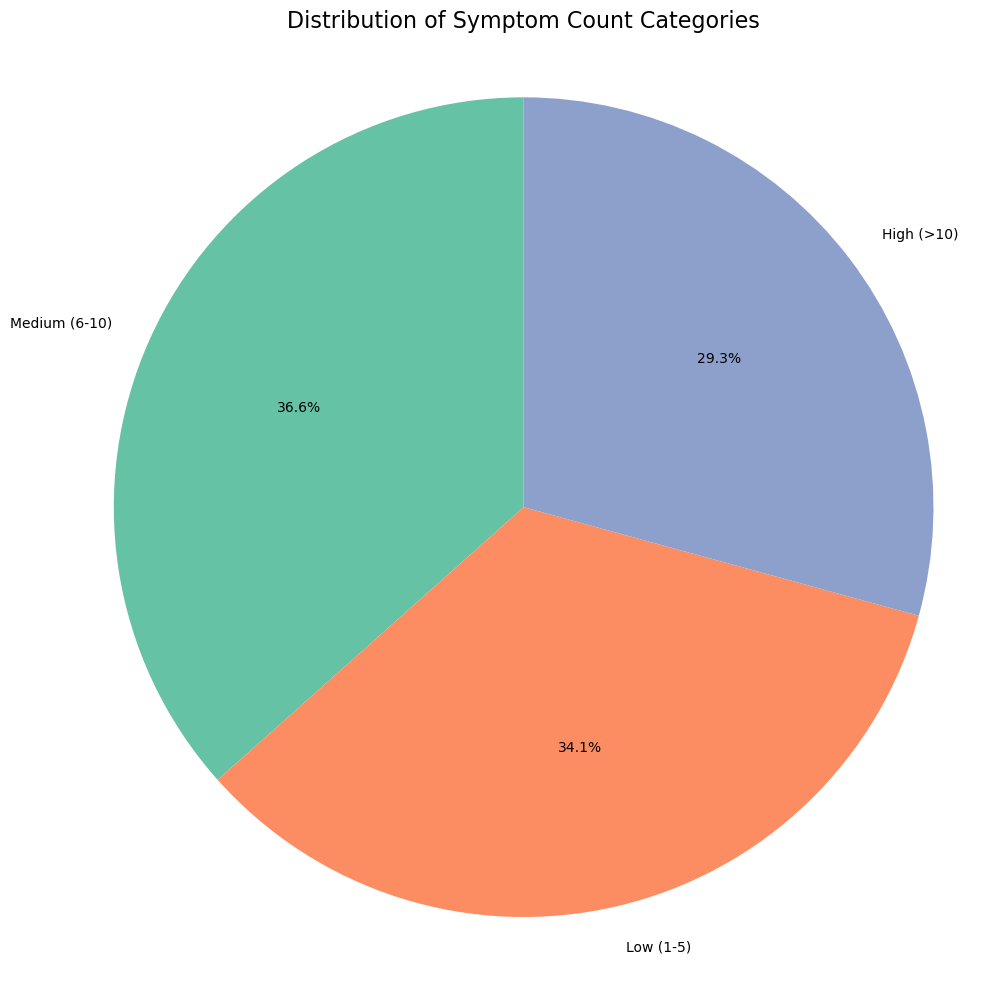

In [21]:
# Pie Chart of Symptom Count Categories
def categorize_count(count):
    if count <= 5:
        return 'Low (1-5)'
    elif count <= 10:
        return 'Medium (6-10)'
    else:
        return 'High (>10)'

symptom_counts_df = pd.DataFrame({'count': symptom_counts})
symptom_counts_df['category'] = symptom_counts_df['count'].apply(categorize_count)
category_counts = symptom_counts_df['category'].value_counts()

plt.figure(figsize=(10, 10))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
plt.title('Distribution of Symptom Count Categories', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.savefig('symptom_count_category.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/vc/zgsxldz91bb2k381f029lrxm0000gn/T/ipykernel_16766/1475270591.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.values, y=category_counts.index,
/var/folders/vc/zgsxldz91bb2k381f029lrxm0000gn/T/ipykernel_16766/1475270591.py:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.barplot(x=category_counts.values, y=category_counts.index,


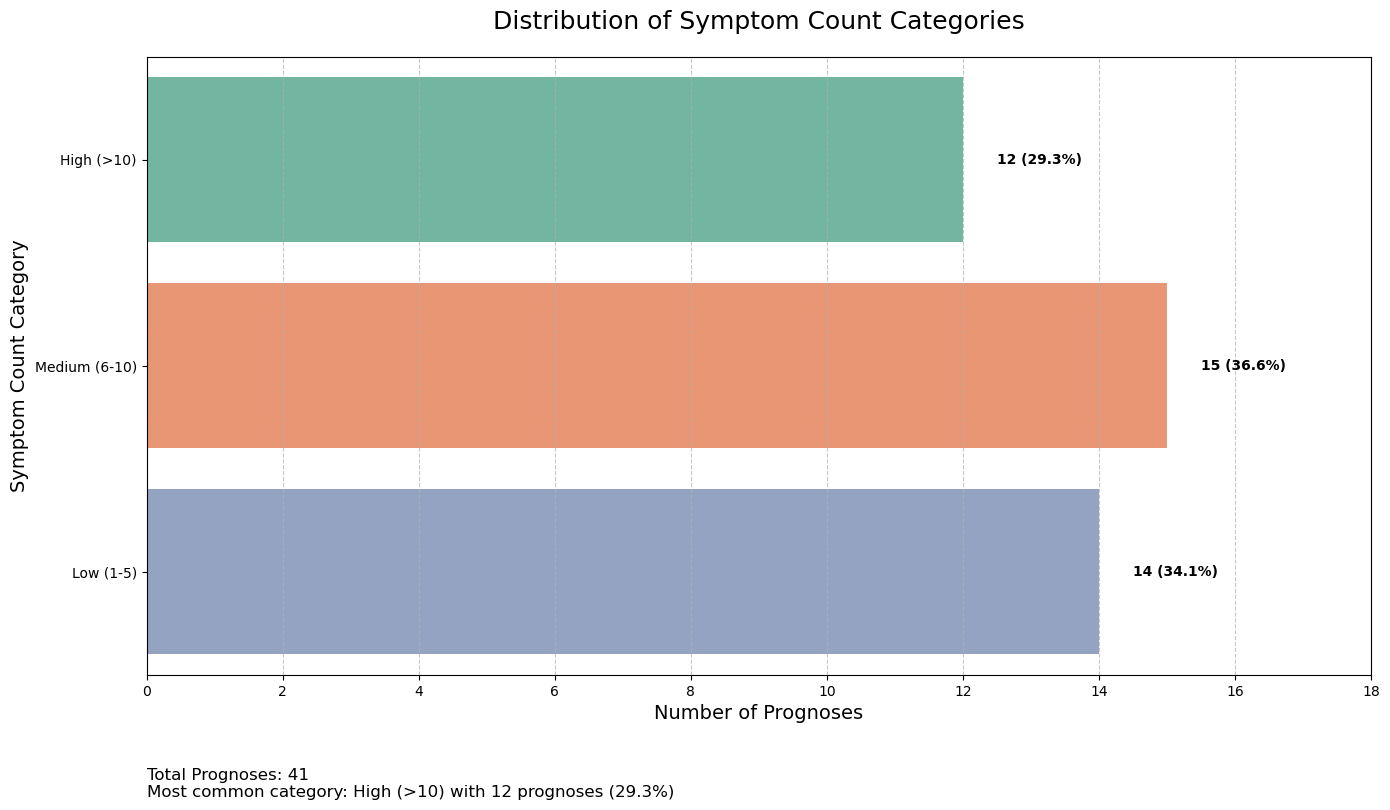

In [24]:
# Sort categories in descending order
category_order = ['High (>10)', 'Medium (6-10)', 'Low (1-5)']
category_counts = symptom_counts_df['category'].value_counts().reindex(category_order)

# Create a horizontal bar chart
plt.figure(figsize=(14, 8))  # Increased figure size for better text placement
ax = sns.barplot(x=category_counts.values, y=category_counts.index, 
                 palette=sns.color_palette("Set2"))

# Add value labels to the right of the bars
for i, v in enumerate(category_counts.values):
    ax.text(v + 0.5, i, f"{v} ({v/len(symptom_counts_df)*100:.1f}%)", 
            va='center', ha='left', color='black', fontweight='bold')

# Customize the plot
plt.title('Distribution of Symptom Count Categories', fontsize=18, pad=20)
plt.xlabel('Number of Prognoses', fontsize=14)
plt.ylabel('Symptom Count Category', fontsize=14)

# Add grid lines
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust x-axis to accommodate external labels
plt.xlim(0, max(category_counts.values) * 1.2)

# Add a brief summary
total_prognoses = len(symptom_counts_df)
plt.text(0, -0.15, 
         f"Total Prognoses: {total_prognoses}\n"
         f"Most common category: {category_counts.index[1]} with {category_counts.values[1]} prognoses "
         f"({category_counts.values[1]/total_prognoses*100:.1f}%)",
         transform=ax.transAxes, fontsize=12, va='top')

# Adjust layout to prevent cutoff
plt.tight_layout()

# Add extra space at the bottom for the summary text
plt.subplots_adjust(bottom=0.15)

plt.show()

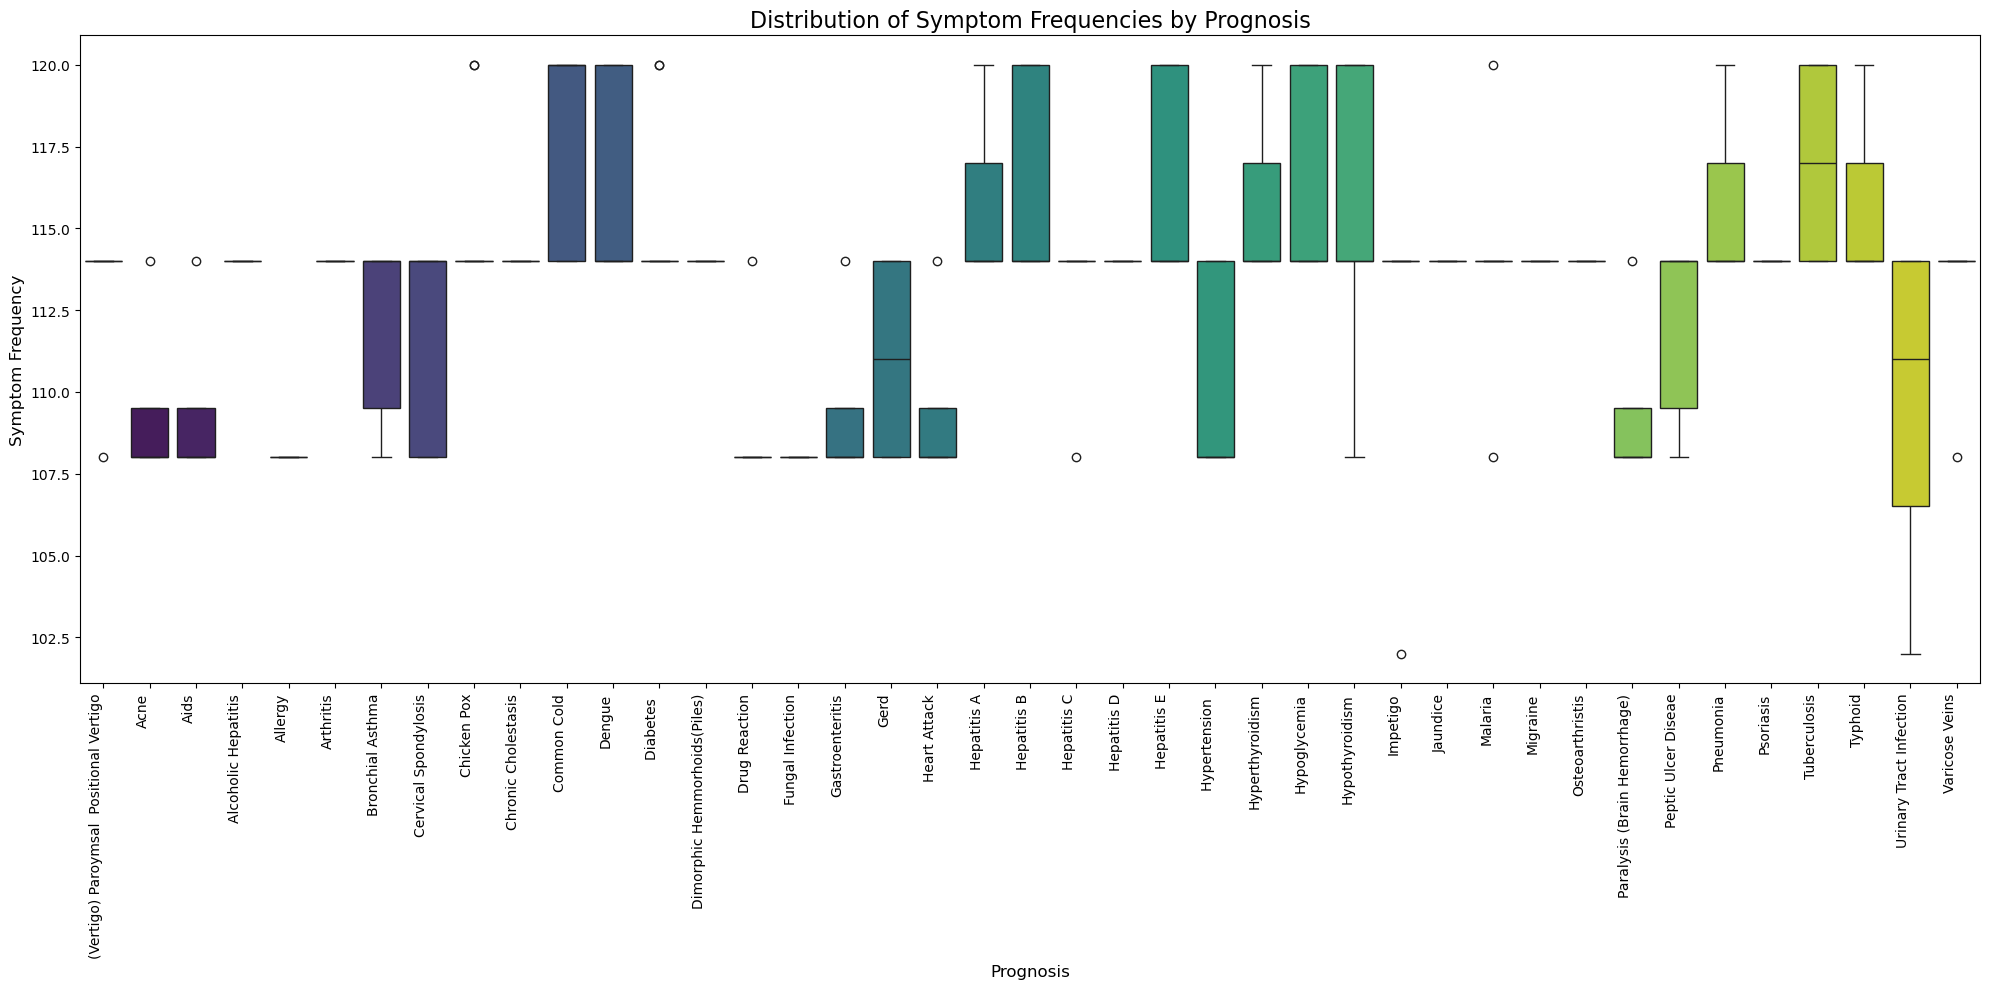

In [33]:
# Box Plot of Symptom Frequencies by Prognosis
plt.figure(figsize=(20, 10))
sns.boxplot(x='prognosis', y='value', hue='prognosis', data=melted_train_data, palette='viridis', legend=False)
plt.title('Distribution of Symptom Frequencies by Prognosis', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.xlabel('Prognosis', fontsize=12)
plt.ylabel('Symptom Frequency', fontsize=12)
plt.tight_layout()
plt.show()

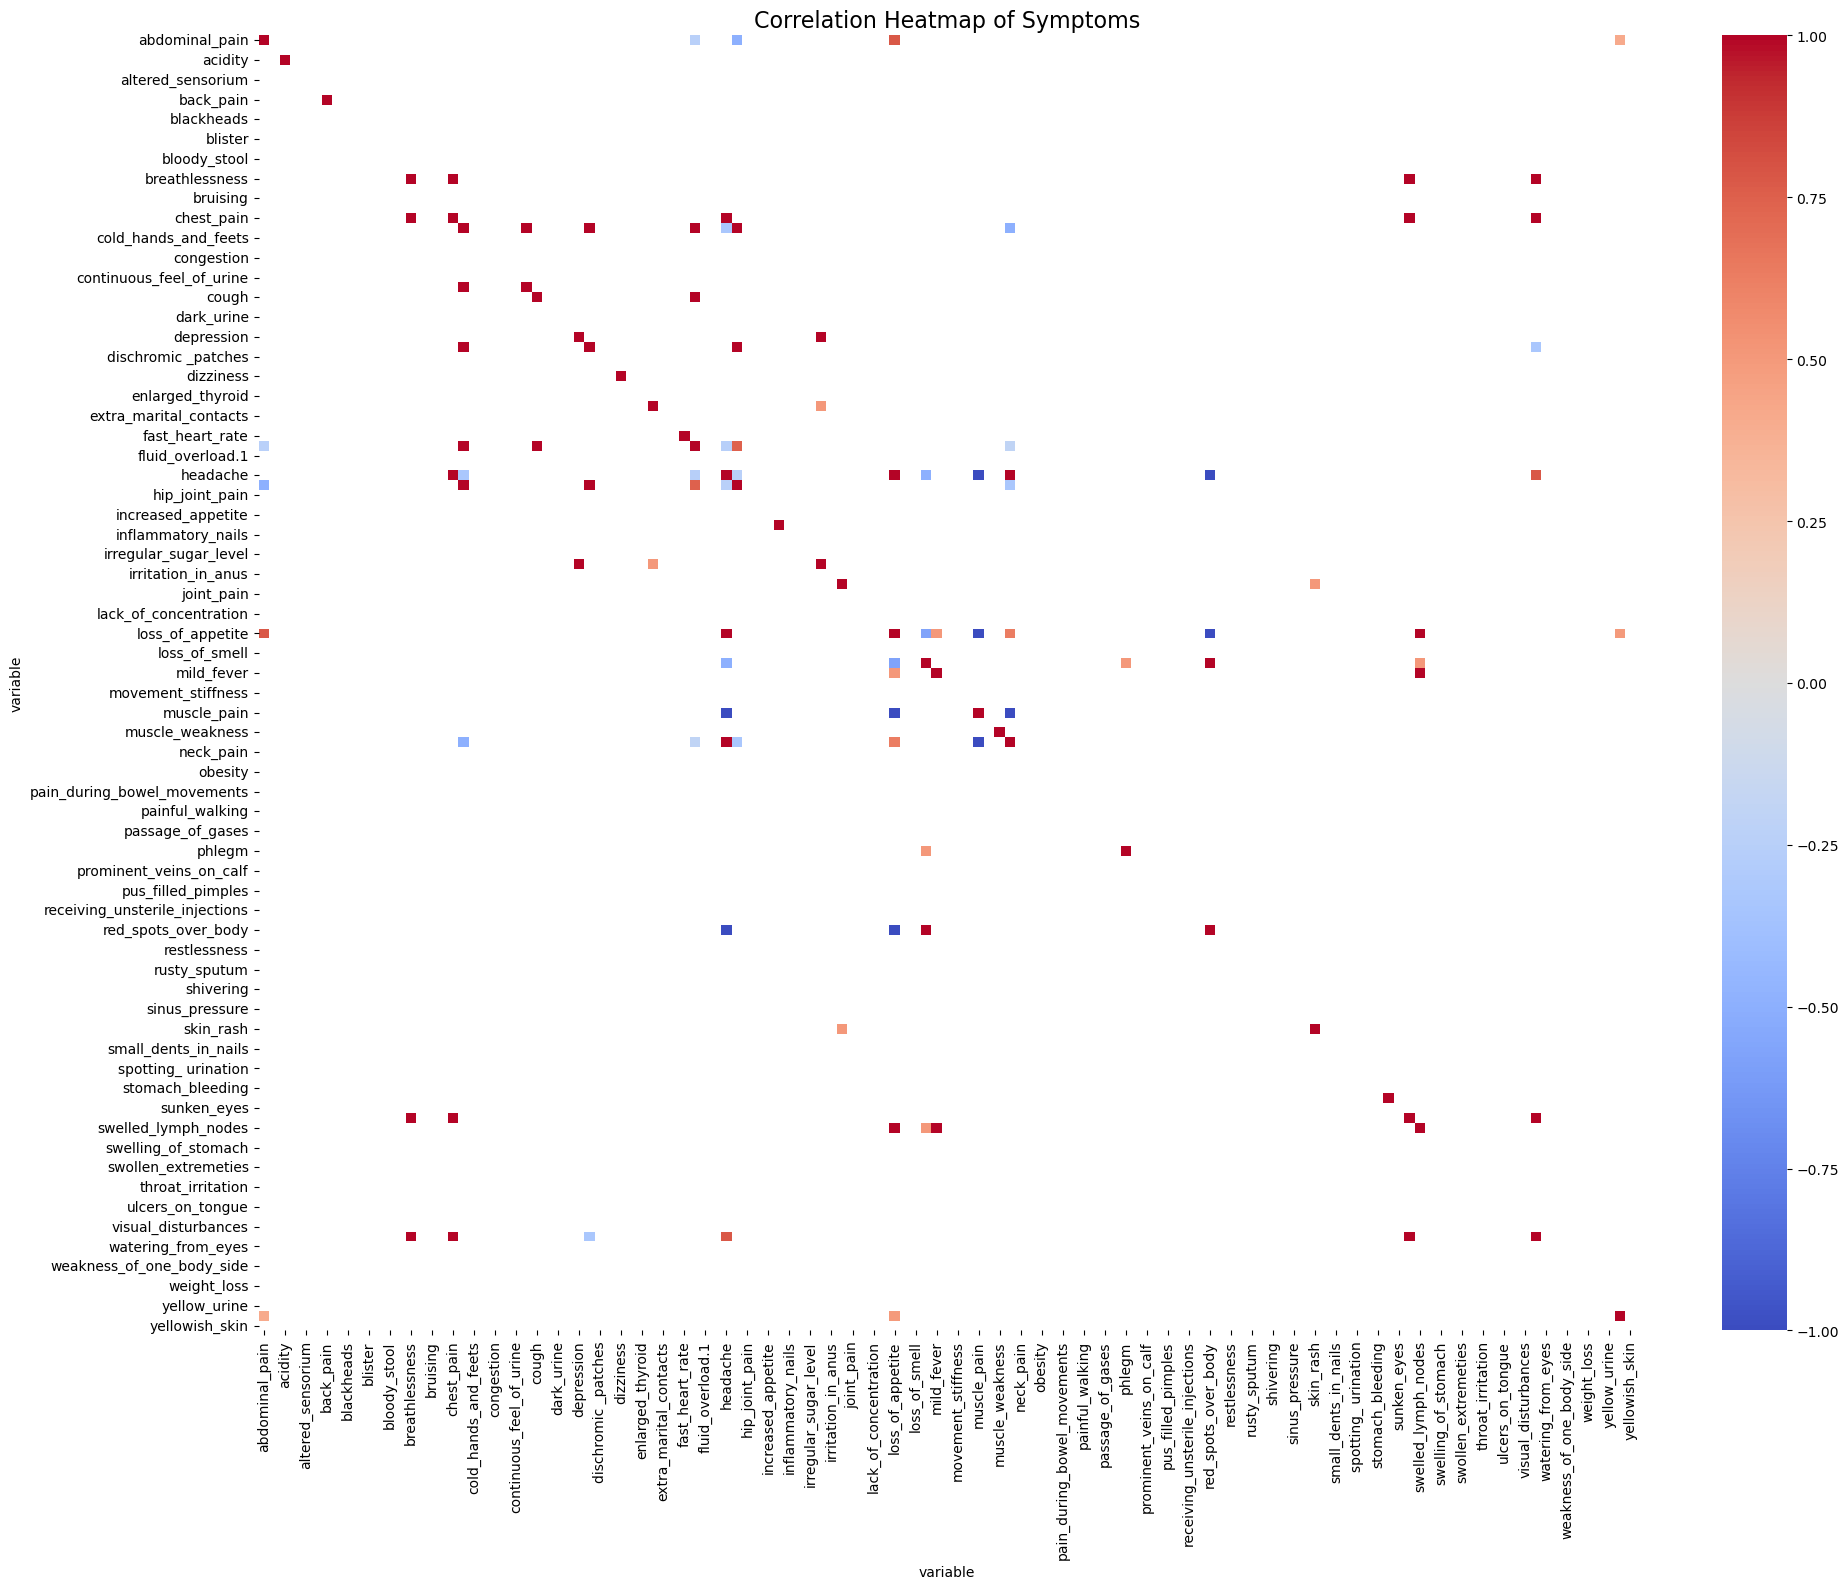

In [36]:
pivot_data = melted_train_data.pivot(index='prognosis', columns='variable', values='value')
correlation_matrix = pivot_data.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap of Symptoms', fontsize=16)
plt.tight_layout()
plt.savefig('symptom_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()